# Setup

In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import ipyparallel as ipp

import sys
sys.path.append('src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pint
import time
import codetimer as ct
import GLE_simulation_v2 as gle
import force_v2 as force

pd.set_option('display.max_rows', 30)
pd.set_option('precision', 5)
np.set_printoptions(edgeitems=5, precision=5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Test Langevin Impulse integration

In [20]:
kB = 1.3806485e-23
D, N = 3, 1

# Physical data for water taken from [Water (data page)](https://en.wikipedia.org/wiki/Water_(data_page))
T = 303.15                  # [K] (30 deg C)
eta = 0.8007e-3             # [Pa*s] = [kg/m/s] (@ 303.15 K)
rhof = 0.9956502e3          # [kg/m^3]          (@ 303.15 K)
rhop = rhof                 # [kg/m^3]
### Vesicle parameters ###
R = 3.2e-7                                  # [m]
m = rhop*(4./3.)*np.pi*R**3                 # [kg]    particle mass 
gam0 = (3*np.pi*R**2*(eta*rhof)**0.5/m)**2  # [1/s]   collision frequency
nu1 = 0.25*gam0     # [1/s]

print 'mass = {:7.4e} kg'.format(m)
print 'gam0 = {:7.4e} 1/s'.format(gam0)
print 'nu1  = {:7.4e} 1/s'.format(nu1)

V0  = 1.0           # [J/m] = [N] amplitude of washboard sinusoidal function
L   = 10.*R         # spatial period of washboard potential/force

print 'V0   = {:7.4e} J/m'.format(V0)
print 'L    = {:7.4e} m'.format(L)

mass = 1.3666e-16 kg
gam0 = 3.9758e+07 1/s
nu1  = 9.9396e+06 1/s
V0   = 1.0000e+00 J/m
L    = 3.2000e-06 m


In [21]:
### Base units ###
Lc  = L                     # length      [m]
Tc  = 1./gam0               # time        [s]
Ec  = m*(Lc/Tc)**2          # energy      [J]
Tec = T                     # temperature [K]
### Derived units ###
Vc  = Lc/Tc                 # velocity    [m/s]
Mc  = Ec/Vc**2              # mass        [kg]
Nc  = Mc/Lc**3              # density     [kg/m^3]
Fc  = Ec/Lc                 # force       [N]

print 'Lc  = {:7.4e} m'.format(Lc)
print 'Mc  = {:7.4e} kg'.format(Mc)
print 'Tc  = {:7.4e} s'.format(Tc)
print 'Nc  = {:7.4e} kg/m^3'.format(Nc)
print 'Vc  = {:7.4e} m/s'.format(Vc)
print 'Ec  = {:7.4e} kg(m/s)^2'.format(Ec)
print 'Fc  = {:7.4e} kg m/s^2'.format(Fc)
print 'Tec = {:7.4e} K'.format(Tec)

dt  = 1.0e-6*Tc     # [s]
print '\n','dt  = {:7.4e} s'.format(dt)

Lc  = 3.2000e-06 m
Mc  = 1.3666e-16 kg
Tc  = 2.5152e-08 s
Nc  = 4.1706e+00 kg/m^3
Vc  = 1.2723e+02 m/s
Ec  = 2.2121e-12 kg(m/s)^2
Fc  = 6.9128e-07 kg m/s^2
Tec = 3.0315e+02 K

dt  = 2.5152e-14 s


---

## Serial execution of GLE washboard simulation

In [26]:
gle_sim = gle.GLESimulation(outname='data/ELI_testwash', method='ELI',
                         Nrep=N, Naux=N, D=2, T=T, L=L, R=R, rhop=rhop, rhof=rhof, eta=eta,
                         gam0=gam0, nu1=nu1, dt=dt, seed=987654)

gle_sim.add_force(force.WashboardForce, 'washboard', V0=V0, L0=L/Lc, C0=0.75)
gle_sim.add_integrator('ELI')

with ct.Timer(unit='secs') as t:
    gle_sim.run(nsteps=100000, tmpsize=100000, ntout=1, printout=1000)
print "– elapsed time: {:.1f} s".format(t.secs)

Registered force "washboard" to the system.
Setting parameters for ELI integrator.
Step 100000 (100.0% complete) Closing trajectory files. Data stored in:
	data
– elapsed time: 5.6 s


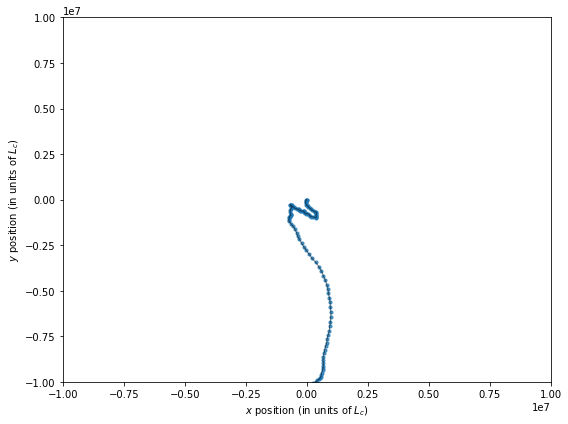

In [27]:
stepi, stepD, stride = 0, 1000, 1
stepf = stepi + stepD

plt.clf()
lims = 1.0e7*np.vstack((-np.ones(3), np.ones(3))).T
fig, ax = gle_sim.quick_plot_2D(start=stepi, stop=stepf, step=stride, lims=lims, figscale=1.5, aspect=0.75)

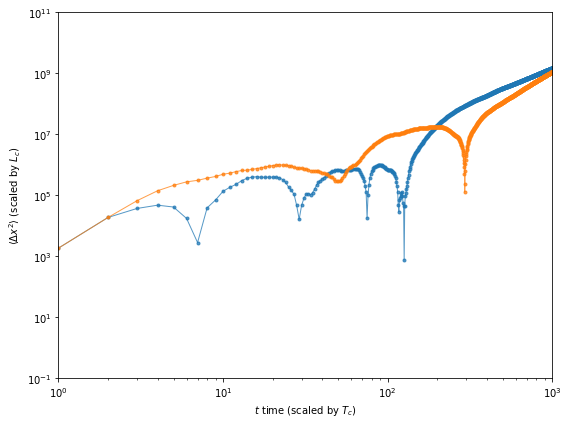

In [28]:
plt.clf()
tlims = [1, 1000]
xlims = np.array([1.0e-1, 1.0e11])
stride = 1
fig, ax = gle_sim.quick_plot_MSD(xlims=xlims, tlims=tlims, step=stride,
                                logscale=True, figscale=1.5, aspect=0.75)

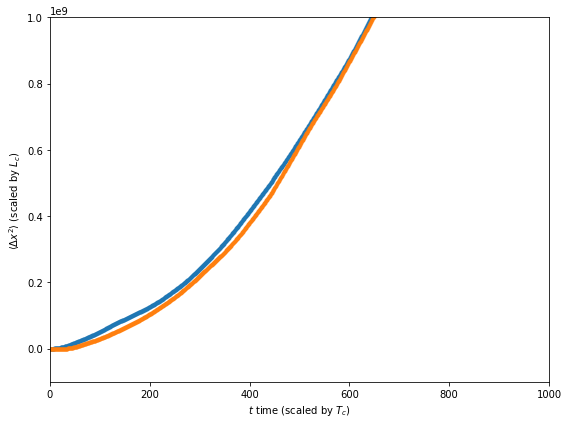

In [25]:
plt.clf()

tlims = [0, 1000]
xlims = 1.0e9*np.array([-0.1, 1.0])
stride = 1
fig, ax = gle_sim.quick_plot_MSD(xlims=xlims, tlims=tlims, step=stride,
                                logscale=False, figscale=1.5, aspect=0.75)

## Parallel execution of GLE washboard simulation

---

---

In [14]:
remote_client = ipp.Client()
direct_view = remote_client[:]
load_balanced_view = remote_client.load_balanced_view()

Try to call map from the direct view with `a` and `b` as the global parameters. This should work because the parameters `a` and `b` in the anonymous function are in the namespace of the ipcluster engines:

In [18]:
a, b = 3, 2
arg1 = np.ones(5)
arg2 = np.array([1,2,3,4,5])
inputs = (arg1, arg2)

In [19]:
res_lambda = direct_view.map(lambda x, y: a*x + b*y**2, *inputs)
print res_lambda.get()

[5.0, 11.0, 21.0, 35.0, 53.0]


This should still work even if we define a separate function, as long as `a` and `b` are available to `f`:

In [20]:
def f(x, y):
    return a*x + b*y**2

In [21]:
res_f = direct_view.map(f, *inputs)
print res_f.get()

[5.0, 11.0, 21.0, 35.0, 53.0]


If, however, `f` is defined in a different module, use `push` to provide the ipcluster engines with access to global variables `a` and `b`:

In [12]:
direct_view.push(dict(a=3, b=2))

<AsyncResult: _push>

---

---

---

In [7]:
sys.path.append('util')

import itertools as it
import parallelizer_v2 as pv2
import parallelizer_v3 as pv3

In [8]:
N_WORKERS = 2
TASK_SIZE = 5

### Generate a bunch of `GLESimulation` objects

In [ ]:
for i in xrange(N_SIMS):
    sims[i].close_trj_files()

In [ ]:
N_SIMS = 10
sims = []
seeds = np.zeros(N_SIMS, dtype=np.int32)

run_kwargs = {"nsteps"   : 1000000,
              "tmpsize"  : 1000000,
              "ntout"    : 10,
              "printout" : 100}

for i in xrange(N_SIMS):
    seeds[i] = i + 987654
    sim = gle.GLESimulation(outname='data/ELI_testwash_{:03n}'.format(i+1), method='ELI',
                         N=N, D=1, T=T, L=L, R=R, rhop=rhop, rhof=rhof, eta=eta,
                         gam0=gam0, nu1=nu1, dt=dt, seed=seeds[i])
    sim.add_force(force.WashboardForce, 'washboard', V0=V0, L0=L/Lc)
    sim.add_integrator('ELI')
    sims.append(sim)
print(' >>> {} simulations initialized.'.format(N_SIMS))

#### `GLEEnsembleSimulator`

In [7]:
import GLEEnsembleSimulator as gle_ens

In [8]:
N_SIMS = 2
sims = []
seeds = np.zeros(N_SIMS, dtype=np.int32)

run_kwargs = {"nsteps"   : 1000000,
              "tmpsize"  : 1000000,
              "ntout"    : 10,
              "printout" : 100}

for i in xrange(N_SIMS):
    seeds[i] = i + 987654
    
ensemble = gle_ens.GLEEnsembleSimulator(N_SIMS, outname='data/ELI_testwash_{:03n}'.format(i+1), method='ELI',
                     N=N, D=1, T=T, L=L, R=R, rhop=rhop, rhof=rhof, eta=eta,
                     gam0=gam0, nu1=nu1, dt=dt, seed=seeds[i])
ensemble.add_force(force.WashboardForce, 'washboard', V0=V0, L0=L/Lc)
ensemble.add_integrator('ELI')

print(' >>> {} simulations initialized.'.format(N_SIMS))

Registered force "washboard" to the system.
Setting parameters for ELI integrator.
 >>> 2 simulations initialized.


In [9]:
import pathos.pools

In [10]:
pathos.pools.ProcessPool?

In [ ]:
ensemble.simulate(**run_kwargs)

#### Parallelizer v2: `multiprocessing`

In [ ]:
par_v2 = pv2.ParallelRun(sims, run_kwargs)

In [ ]:
par_v2.run(N_WORKERS=N_WORKERS)
pv2_mp = par_v2.results

#### Parallelizer v3: `map_async`

In [ ]:
par_v3_map_async = pv3.Parallelizer(hausdorff_c2, path_pairs, data_size=N_PAIRS)

In [ ]:
par_v3_map_async.run(N_WORKERS=N_WORKERS, TASK_SIZE=TASK_SIZE, method='map_async')
pv3_map_async = par_v3_map_async.results

#### Parallelizer v3: `imap`

In [ ]:
par_v3_imap = pv3.Parallelizer(hausdorff_c2, path_pairs, data_size=N_PAIRS)

In [ ]:
par_v3_imap.run(N_WORKERS=N_WORKERS, TASK_SIZE=TASK_SIZE, method='imap')
pv3_imap = par_v3_imap.results

#### Parallelizer v3: `imap_unordered`

In [ ]:
par_v3_imap_unord = pv3.Parallelizer(hausdorff_c2, path_pairs, data_size=N_PAIRS)

In [ ]:
par_v3_imap_unord.run(N_WORKERS=N_WORKERS, TASK_SIZE=TASK_SIZE, method='imap_unordered')
pv3_imap_unord = par_v3_imap_unord.results

---